# Naive Bayes Classification

Conditional independence is useful when dealing with data, since it simplifies a lot of equations. A popular (and very simple) algorithm is the Naive Bayes Classifier.
Its key assumption is that the attributes are all independent of each other, given the labels. In other words, we have:

$$p(\mathbf{x} | y) = \prod_i p(x_i | y)$$

Using Bayes Theorem this leads to the classifier $p(y | \mathbf{x}) = \frac{\prod_i p(x_i | y) p(y)}{p(\mathbf{x})}$. Unfortunately, this is still intractable, since we don't know $p(x)$. Fortunately, we don't need it, since we know that $\sum_y p(y | \mathbf{x}) = 1$, hence we can always recover the normalization from

$$p(y | \mathbf{x}) \propto \prod_i p(x_i | y) p(y).$$

To illustrate this a bit, consider classifying emails into spam and ham. It's fair to say that the occurrence of the words `Nigeria`, `prince`, `money`, `rich` are all likely indicators that the e-mail might be spam, whereas `theorem`, `network`, `Bayes` or `statistics` are pretty good indicators that there's substance in the message. Thus, we could model the probability of occurrence for each of these words, given the respective class and then use it to score the likelihood of a text. In fact, for a long time this *is* what many so-called [Bayesian spam filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering) used.

## Optical Character Recognition

Since images are much easier to deal with, we will illustrate the workings of a Naive Bayes classifier for distinguishing digits on the MNIST dataset. The problem is that we don't actually know $p(y)$ and $p(x_i | y)$. So we need to *estimate* it given some training data first. This is what is called *training* the model. Estimating $p(y)$ is not too hard. Since we are only dealing with 10 classes, this is pretty easy - simply count the number of occurrences $n_y$ for each of the digits and divide it by the total amount of data $n$. For instance, if digit 8 occurs $n_8 = 5,800$ times and we have a total of $n = 60,000$ images, the probability estimate is $p(y=8) = 0.0967$.

Now on to slightly more difficult things - $p(x_i | y)$. Since we picked black and white images, $p(x_i | y)$ denotes the probability that pixel $i$ is switched on for class $y$. Just like before we can go and count the number of times $n_{iy}$ such that an event occurs and divide it by the total number of occurrences of y, i.e. $n_y$. But there's something slightly troubling: certain pixels may never be black (e.g. for very well cropped images the corner pixels might always be white). A convenient way for statisticians to deal with this problem is to add pseudo counts to all occurrences. Hence, rather than $n_{iy}$ we use $n_{iy}+1$ and instead of $n_y$ we use $n_{y} + 1$. This is also called [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import mxnet as mx
from mxnet import nd
import numpy as np

# We go over one observation at a time (speed doesn't matter here)
def transform(data, label):
    return (nd.floor(data/128)).astype(np.float32), label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test  = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# Initialize the counters
xcount = nd.ones((784,10))
ycount = nd.ones((10))

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# using broadcast again for division
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

Now that we computed per-pixel counts of occurrence for all pixels, it's time to see how our model behaves. Time to plot it. This is where it is so much more convenient to work with images. Visualizing 28x28x10 probabilities (for each pixel for each class) would typically be an exercise in futility. However, by plotting them as images we get a quick overview. The astute reader probably noticed by now that these are some mean looking digits ...

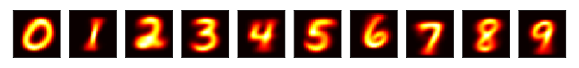

Class probabilities 
[0.09871688 0.11236461 0.09930012 0.10218297 0.09736711 0.09035161
 0.09863356 0.10441593 0.09751708 0.09915014]
<NDArray 10 @cpu(0)>


In [2]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print('Class probabilities', py)

Now we can compute the likelihoods of an image, given the model. This is statistician speak for $p(x | y)$, i.e. how likely it is to see a particular image under certain conditions (such as the label). Our Naive Bayes model which assumed that all pixels are independent tells us that

$$p(\mathbf{x} | y) = \prod_{i} p(x_i | y)$$

Using Bayes' rule, we can thus compute $p(y | \mathbf{x})$ via

$$p(y | \mathbf{x}) = \frac{p(\mathbf{x} | y) p(y)}{\sum_{y'} p(\mathbf{x} | y')}$$

Let's try this ...

In [3]:
# Get the first test item
data, label = mnist_test[0]
data = data.reshape((784,1))

# Compute the per pixel conditional probabilities
xprob = (px * data + (1-px) * (1-data))
# Take the product
xprob = xprob.prod(0) * py
print('Unnormalized Probabilities', xprob)
# Normalize
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Probabilities 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 10 @cpu(0)>
Normalized Probabilities 
[nan nan nan nan nan nan nan nan nan nan]
<NDArray 10 @cpu(0)>


This went horribly wrong! To find out why, let's look at the per pixel probabilities. They're typically numbers between $0.001$ and $1$. We are multiplying $784$ of them. At this point it is worth mentioning that we are calculating these numbers on a computer, hence with a fixed range for the exponent. What happens is that we experience *numerical underflow*, i.e. multiplying all the small numbers leads to something even smaller until it is rounded down to zero. At that point we get division by zero with `nan` as a result.

To fix this we use the fact that $\log a b = \log a + \log b$, i.e. we switch to summing logarithms. This will get us unnormalized probabilities in log-space. To normalize terms we use the fact that

$$\frac{\exp(a)}{\exp(a) + \exp(b)} = \frac{\exp(a + c)}{\exp(a + c) + \exp(b + c)}$$

In particular, we can pick $c = -\max(a,b)$, which ensures that at least one of the terms in the denominator is $1$.

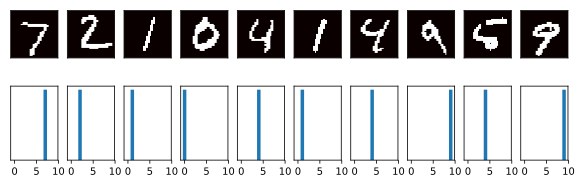

In [4]:
logpx = nd.log(px)
logpxneg = nd.log(1-px)
logpy = nd.log(py)

def bayespost(data):
    # We need to incorporate the prior probability p(y) since p(y|x) is
    # proportional to p(x|y) p(y)
    logpost = logpy.copy()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    # Normalize to prevent overflow or underflow by subtracting the largest
    # value
    logpost -= nd.max(logpost)
    # Compute the softmax using logpx
    post = nd.exp(logpost).asnumpy()
    post /= np.sum(post)
    return post

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))

# Show 10 images
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)

    # Bar chart and image of digit
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1

    if ctr == 10:
        break

plt.show()

As we can see, this classifier works pretty well in many cases. However, the second last digit shows that it can be both incompetent and overly confident of its incorrect estimates. That is, even if it is horribly wrong, it generates probabilities close to 1 or 0. Not a classifier we should use very much nowadays any longer. To see how well it performs overall, let's compute the overall accuracy of the classifier.

In [5]:
# Initialize counter
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)

Naive Bayes has an error rate of 0.1574


Modern deep networks achieve error rates of less than 0.01. While Naive Bayes classifiers used to be popular in the 80s and 90s, e.g. for spam filtering, their heydays are over. The poor performance is due to the incorrect statistical assumptions that we made in our model: we assumed that each and every pixel are *independently* generated, depending only on the label. This is clearly not how humans write digits, and this wrong assumption led to the downfall of our overly naive (Bayes) classifier. Time to start building Deep Networks.

## Summary

* Naive Bayes is an easy to use classifier that uses the assumption
  $p(\mathbf{x} | y) = \prod_i p(x_i | y)$.
* The classifier is easy to train but its estimates can be very wrong.
* To address overly confident and nonsensical estimates, the
  probabilities $p(x_i|y)$ are smoothed, e.g. by Laplace
  smoothing. That is, we add a constant to all counts.
* Naive Bayes classifiers don't exploit any correlations between
  observations.

## Exercises

1. Design a Naive Bayes regression estimator where $p(x_i | y)$ is a normal distribution.
1. Under which situations does Naive Bayes work?
1. An eyewitness is sure that he could recognize the perpetrator with 90% accuracy, if he were to encounter him again.
   * Is this a useful statement if there are only 5 suspects?
   * Is it still useful if there are 50?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2320)

![](../img/qr_naive-bayes.svg)